In [11]:
import os
from collections import Counter
from pathlib import Path
import re

import anndata
import altair as alt
import pandas as pd
import numpy as np
import scipy
import scanpy as sc
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler


import mgitools.os_helpers as os_helpers

In [18]:
from pollock.models.model import predict_from_anndata, embed_from_anndata, balancedish_training_generator
from pollock.models.explain import explain_predictions

In [14]:
benchmarking_results = '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2'
fps = sorted(os_helpers.listfiles(benchmarking_results, regex=r'pollock_module$'))
module_map = {fp.split('/')[-3]:{} for fp in fps}
for fp in fps:
    dtype = fp.split('/')[-3]
    disease = fp.split('/')[-2]
    module_map[dtype][disease] = fp
module_map

{'scRNAseq': {'brca': '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/brca/pollock_module',
  'cesc': '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/cesc/pollock_module',
  'hnscc': '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/hnscc/pollock_module',
  'melanoma': '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/melanoma/pollock_module',
  'myeloma': '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/myeloma/pollock_module',
  'pdac': '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/pdac/pollock_module'},
 'snATACseq': {'brca_gene_activity': '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/brca_gene_activity/pollock_module',
  'brca_motif': '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/brca_motif/pollock_module',
  'ccrcc_gene_activity': '/home/estorrs/pollock/benc

In [12]:
DATA_DIR = '/home/estorrs/pollock/benchmarking/data/01272021_harmonized/teir_1/'
fps = sorted(os_helpers.listfiles(DATA_DIR, regex='.h5ad$'))
adata_map = {fp.split('/')[-2]:{} for fp in fps}
for fp in fps:
    dtype = fp.split('/')[-2]
    disease = re.sub(r'^(.*)((_train)|(_val)).h5ad$', r'\1', fp.split('/')[-1])
    if 'peaks' not in disease:
        if disease not in adata_map[dtype] and '.h5ad' not in disease: adata_map[dtype][disease] = {}
        if 'train.h5ad' in fp:
            adata_map[dtype][disease]['train'] = fp
        if 'val.h5ad' in fp:
            adata_map[dtype][disease]['val'] = fp
for dtype, d in adata_map.items():
    for disease, m in d.items():
        print(dtype, disease)

scRNAseq brca
scRNAseq cesc
scRNAseq hnscc
scRNAseq melanoma
scRNAseq myeloma
scRNAseq pdac
snATACseq brca_gene_activity
snATACseq brca_motif
snATACseq brca
snATACseq ccrcc_gene_activity
snATACseq ccrcc_motif
snATACseq ccrcc
snATACseq gbm_gene_activity
snATACseq gbm_motif
snATACseq gbm
snRNAseq brca
snRNAseq ccrcc
snRNAseq gbm


In [13]:
# only do it for scRNA, snRNA, and gene_activity
adata_map['snATACseq'].pop('brca_motif')
adata_map['snATACseq'].pop('brca')
adata_map['snATACseq'].pop('ccrcc_motif')
adata_map['snATACseq'].pop('ccrcc')
adata_map['snATACseq'].pop('gbm_motif')
adata_map['snATACseq'].pop('gbm')
adata_map['snRNAseq'].pop('ccrcc')


{'train': '/home/estorrs/pollock/benchmarking/data/01272021_harmonized/teir_1/snRNAseq/ccrcc_train.h5ad',
 'val': '/home/estorrs/pollock/benchmarking/data/01272021_harmonized/teir_1/snRNAseq/ccrcc_val.h5ad'}

In [17]:
for k, v in adata_map.items():
    for k2 in v.keys():
        if k in module_map and k2 in module_map[k]:
            print(k, k2)

scRNAseq brca
scRNAseq cesc
scRNAseq hnscc
scRNAseq melanoma
scRNAseq myeloma
scRNAseq pdac
snATACseq brca_gene_activity
snATACseq ccrcc_gene_activity
snATACseq gbm_gene_activity
snRNAseq brca
snRNAseq gbm


In [21]:
inputs = {}
to_explained = {}
for dtype, v in adata_map.items():
    inputs[dtype] = {}
    to_explained[dtype] = {}
    for disease in v.keys():
        if dtype in module_map and disease in module_map[dtype]:
            print(dtype, disease)
            adata = sc.read_h5ad(adata_map[dtype][disease]['val'])
            explain, rest = balancedish_training_generator(adata, cell_type_key='cell_type',
                                                   n_per_cell_type=25, oversample=False, split=1.)
            background, _ = balancedish_training_generator(rest, cell_type_key='cell_type',
                                                           n_per_cell_type=5, split=1.)
            print(explain.shape)
            print(Counter(explain.obs['cell_type']))

            print(disease, explain.shape)
            w = explain_predictions(explain.copy(), background.copy(), module_map[dtype][disease],
                                    prediction_key='cell_type')
            to_explained[dtype][disease] = w


scRNAseq brca
(325, 27131)
Counter({'Endothelial': 25, 'CD4 T cell': 25, 'NK': 25, 'CD8 T cell': 25, 'Malignant': 25, 'Mast': 25, 'Monocyte': 25, 'Fibroblast': 25, 'B cell': 25, 'Dendritic': 25, 'Treg': 25, 'Plasma': 25, 'Erythrocyte': 25})
brca (325, 27131)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 11:01:25,284 0 genes in training set are missing from prediction set
2021-04-21 11:01:26,594 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 11:01:26,717 0 genes in training set are missing from prediction set
2021-04-21 11:01:28,249 0 genes in training set are missing from prediction set
2021-04-21 11:01:28,983 (325, 27131)


scRNAseq cesc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(264, 22928)
Counter({'Monocyte': 25, 'Mast': 25, 'Fibroblast': 25, 'Endothelial': 25, 'CD8 T cell': 25, 'Epithelial': 25, 'Plasma': 25, 'CD4 T cell': 25, 'Malignant': 25, 'NK': 25, 'Erythrocyte': 14})
cesc (264, 22928)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 11:22:04,837 0 genes in training set are missing from prediction set
2021-04-21 11:22:05,261 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 11:22:05,321 0 genes in training set are missing from prediction set
2021-04-21 11:22:06,397 0 genes in training set are missing from prediction set
2021-04-21 11:22:06,897 (264, 22928)


scRNAseq hnscc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(275, 26929)
Counter({'Monocyte': 25, 'CD4 T cell': 25, 'Plasma': 25, 'B cell': 25, 'Treg': 25, 'Malignant': 25, 'Mast': 25, 'Erythrocyte': 25, 'NK': 25, 'CD8 T cell': 25, 'Endothelial': 25})
hnscc (275, 26929)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 11:48:14,080 0 genes in training set are missing from prediction set
2021-04-21 11:48:14,647 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 11:48:14,716 0 genes in training set are missing from prediction set
2021-04-21 11:48:15,844 0 genes in training set are missing from prediction set
2021-04-21 11:48:16,506 (275, 26929)


scRNAseq melanoma


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(250, 23452)
Counter({'B cell': 25, 'NK': 25, 'CD8 T cell': 25, 'Treg': 25, 'Dendritic': 25, 'Fibroblast': 25, 'Monocyte': 25, 'CD4 T cell': 25, 'Plasma': 25, 'Malignant': 25})
melanoma (250, 23452)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 12:09:49,540 0 genes in training set are missing from prediction set
2021-04-21 12:09:50,023 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 12:09:50,321 0 genes in training set are missing from prediction set
2021-04-21 12:09:51,160 0 genes in training set are missing from prediction set
2021-04-21 12:09:51,618 (250, 23452)


scRNAseq myeloma
(208, 24020)
Counter({'Malignant': 25, 'Monocyte': 25, 'Dendritic': 25, 'NK': 25, 'CD4 T cell': 25, 'CD8 T cell': 25, 'B cell': 25, 'Erythrocyte': 21, 'Mast': 4, 'Platlete': 4, 'Plasma': 4})
myeloma (208, 24020)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 12:27:26,907 0 genes in training set are missing from prediction set
2021-04-21 12:27:27,467 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 12:27:27,555 0 genes in training set are missing from prediction set
2021-04-21 12:27:28,372 0 genes in training set are missing from prediction set
2021-04-21 12:27:28,900 (208, 24020)


scRNAseq pdac


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(425, 28756)
Counter({'Tuft': 25, 'Epithelial': 25, 'Treg': 25, 'Plasma': 25, 'Dendritic': 25, 'NK': 25, 'Monocyte': 25, 'CD8 T cell': 25, 'Erythrocyte': 25, 'Islet': 25, 'Fibroblast': 25, 'Mast': 25, 'Endothelial': 25, 'CD4 T cell': 25, 'Malignant': 25, 'Acinar': 25, 'B cell': 25})
pdac (425, 28756)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 13:08:24,523 0 genes in training set are missing from prediction set
2021-04-21 13:08:25,157 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 13:08:25,269 0 genes in training set are missing from prediction set
2021-04-21 13:08:27,159 0 genes in training set are missing from prediction set
2021-04-21 13:08:27,928 (425, 28756)


snATACseq brca_gene_activity


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(194, 19891)
Counter({'Fibroblast': 25, 'Dendritic': 25, 'Monocyte': 25, 'T cells': 25, 'B cell': 25, 'Malignant': 25, 'Endothelial': 25, 'Mast': 19})
brca_gene_activity (194, 19891)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 13:24:29,575 0 genes in training set are missing from prediction set
2021-04-21 13:24:30,143 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 13:24:30,207 0 genes in training set are missing from prediction set
2021-04-21 13:24:31,248 0 genes in training set are missing from prediction set
2021-04-21 13:24:31,706 (194, 19891)


snATACseq ccrcc_gene_activity
(150, 19843)
Counter({'Epithelial': 25, 'Monocyte': 25, 'Fibroblast': 25, 'Endothelial': 25, 'T cells': 25, 'Malignant': 25})
ccrcc_gene_activity (150, 19843)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 13:36:33,675 0 genes in training set are missing from prediction set
2021-04-21 13:36:34,236 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 13:36:34,310 0 genes in training set are missing from prediction set
2021-04-21 13:36:35,109 0 genes in training set are missing from prediction set
2021-04-21 13:36:35,548 (150, 19843)


snATACseq gbm_gene_activity
(200, 19891)
Counter({'Malignant': 25, 'Fibroblast': 25, 'Oligodendrocytes': 25, 'T cells': 25, 'B cell': 25, 'Endothelial': 25, 'Microglia': 25, 'Neuron': 25})
gbm_gene_activity (200, 19891)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 13:52:00,245 0 genes in training set are missing from prediction set
2021-04-21 13:52:00,674 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 13:52:01,076 0 genes in training set are missing from prediction set
2021-04-21 13:52:02,044 0 genes in training set are missing from prediction set
2021-04-21 13:52:02,401 (200, 19891)


snRNAseq brca


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(315, 29175)
Counter({'NK': 25, 'Fibroblast': 25, 'Malignant': 25, 'Mast': 25, 'Endothelial': 25, 'Adipocyte': 25, 'Monocyte': 25, 'CD4 T cell': 25, 'Treg': 25, 'B cell': 25, 'CD8 T cell': 25, 'Plasma': 25, 'Dendritic': 15})
brca (315, 29175)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 14:22:39,209 0 genes in training set are missing from prediction set
2021-04-21 14:22:39,890 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 14:22:39,972 0 genes in training set are missing from prediction set
2021-04-21 14:22:41,294 0 genes in training set are missing from prediction set
2021-04-21 14:22:42,098 (315, 29175)


snRNAseq gbm


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(225, 29748)
Counter({'Malignant': 25, 'Microglia': 25, 'B cell': 25, 'Fibroblast': 25, 'Endothelial': 25, 'Neuron': 25, 'Oligodendrocytes': 25, 'T cells': 25, 'Monocyte': 25})
gbm (225, 29748)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 14:44:24,150 0 genes in training set are missing from prediction set
2021-04-21 14:44:24,730 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 14:44:24,791 0 genes in training set are missing from prediction set
2021-04-21 14:44:26,076 0 genes in training set are missing from prediction set
2021-04-21 14:44:26,767 (225, 29748)


In [22]:
to_explained['scRNAseq']['pdac']

,OR4F5,AL627309.1,AL627309.3,AL627309.4,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,...,AL592183.1,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1
HT056P_S1PA_AACAACCGTAGCGATG-1,0.0,0.0,0.0,0.0,0.0,0.000028,0.0,0.0,1.191398e-04,0.0,...,0.000038,0.0,0.000042,0.0,2.289906e-05,0.0,0.000000,0.0,0.0,0.0
HT056P_S1PA_AACAAGACACATTCGA-1,0.0,0.0,0.0,0.0,0.0,0.000061,0.0,0.0,2.237434e-05,0.0,...,0.000013,0.0,0.000023,0.0,1.348171e-05,0.0,0.000000,0.0,0.0,0.0
HT056P_S1PA_AACCTGATCCTACTGC-1,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,1.166351e-05,0.0,...,0.000012,0.0,0.000014,0.0,1.256788e-06,0.0,0.000000,0.0,0.0,0.0
HT056P_S1PA_AAGGTAACAGGTTACT-1,0.0,0.0,0.0,0.0,0.0,0.000064,0.0,0.0,5.412656e-05,0.0,...,0.000143,0.0,0.000035,0.0,6.333377e-06,0.0,0.000000,0.0,0.0,0.0
HT056P_S1PA_ACGGGTCCAAGGTCTT-1,0.0,0.0,0.0,0.0,0.0,0.000011,0.0,0.0,1.349163e-05,0.0,...,0.000007,0.0,0.000008,0.0,3.071054e-08,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H3_TACACCCTCAACGAGG-1,0.0,0.0,0.0,0.0,0.0,0.000011,0.0,0.0,5.609338e-05,0.0,...,0.000072,0.0,0.000000,0.0,3.099980e-05,0.0,0.000000,0.0,0.0,0.0
HT168P1_S1H3_TAGTGCATCTCGACGG-1,0.0,0.0,0.0,0.0,0.0,0.000029,0.0,0.0,1.453364e-05,0.0,...,0.000011,0.0,0.000015,0.0,5.837398e-06,0.0,0.000000,0.0,0.0,0.0
HT168P1_S1H3_TCCGATCTCCATAGGT-1,0.0,0.0,0.0,0.0,0.0,0.000014,0.0,0.0,3.340290e-05,0.0,...,0.000039,0.0,0.000026,0.0,1.189619e-05,0.0,0.000000,0.0,0.0,0.0
HT168P1_S1H3_TCGACGGTCATGCATG-1,0.0,0.0,0.0,0.0,0.0,0.000013,0.0,0.0,4.039508e-05,0.0,...,0.000071,0.0,0.000005,0.0,3.094770e-06,0.0,0.000439,0.0,0.0,0.0


In [23]:
import anndata
explain = None
adatas = []
for dtype, d in to_explained.items():
    for disease, df in d.items():
        og = sc.read_h5ad(adata_map[dtype][disease]['val'])
        og = og[df.index].copy()
        new = anndata.AnnData(X=df.values, obs=og.obs)
        new.var.index = df.columns
        new.obs['disease'] = disease
        new.obs['datatype'] = dtype
        adatas.append(new)

        feature_adata = new.copy()

        if explain is None:
            explain = feature_adata
        else:
            explain = anndata.concat((explain, feature_adata))

explain
    

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 2831 × 14136
    obs: 'orig.ident', 'cell_type', 'disease', 'datatype'

In [24]:
explain.write_h5ad('../benchmarking/sandbox/explain_042121.h5ad')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'orig.ident' as categorical
... storing 'cell_type' as categorical
... storing 'disease' as categorical
... storing 'datatype' as categorical


In [49]:
pdac = explain[explain.obs['disease']=='pdac']
pdac

View of AnnData object with n_obs × n_vars = 425 × 14136
    obs: 'orig.ident', 'cell_type', 'disease', 'datatype'

In [50]:
feature_adata = pdac.copy()

sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 425 × 14136
    obs: 'orig.ident', 'cell_type', 'disease', 'datatype'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [51]:
set(feature_adata.obs['cell_type'])

{'Acinar',
 'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Endothelial',
 'Epithelial',
 'Erythrocyte',
 'Fibroblast',
 'Islet',
 'Malignant',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg',
 'Tuft'}

In [52]:
marker_genes = {
    'Acinar': ['PRSS2'],
    'B cell': ['MS4A1'],
    'CD4 T cell': ['CD3G', 'CD4', 'IL7R'],
    'CD8 T cell': ['CD3G', 'CD8A'],
    'Dendritic': ['ITGAX','IDO1'],
    'Endothelial': ['PECAM1'],
    'Erythrocyte': ['HBD'],
    'Fibroblast': ['ACTA2'],
#     'Islet': ['CHGA'],
    'Malignant/Epithelial': ['EPCAM', 'KRT18'],
    'Mast': ['KIT', 'FCER1A'],
    'Monocyte': ['CD14', 'FCGR3A', 'LYZ'],
    'NK': ['GNLY', 'CD7'],
    'Plasma': ['SDC1'],
    'Treg': ['FOXP3'],
}

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


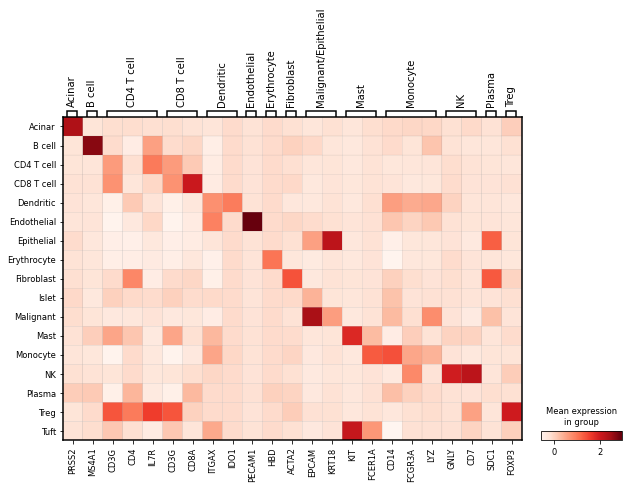

In [82]:
sc.pl.matrixplot(feature_adata, marker_genes, groupby='cell_type', cmap='Reds')

In [74]:
adata = sc.read_h5ad(adata_map['scRNAseq']['pdac']['val'])
adata

AnnData object with n_obs × n_vars = 7823 × 28756
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'ident'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [75]:
emb = embed_from_anndata(adata, module_map['scRNAseq']['pdac'])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 15:43:34,343 0 genes in training set are missing from prediction set
2021-04-21 15:43:34,889 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 15:43:35,025 0 genes in training set are missing from prediction set


In [76]:
import umap
adata.obsm['X_umap'] = umap.UMAP().fit_transform(emb.values)

In [77]:
pred = predict_from_anndata(adata, module_map['scRNAseq']['pdac'])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 15:44:05,587 0 genes in training set are missing from prediction set
2021-04-21 15:44:06,102 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-21 15:44:06,240 0 genes in training set are missing from prediction set


In [78]:
adata.obs = pd.merge(adata.obs, pred, left_index=True, right_index=True)

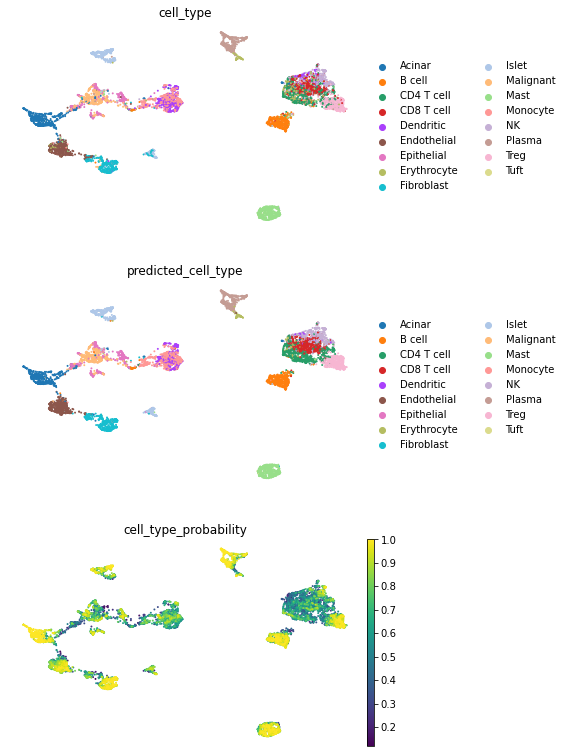

In [81]:
sc.pl.umap(adata, color=['cell_type', 'predicted_cell_type', 'cell_type_probability'], ncols=1,
          frameon=False)